# Exploratory Data Analysis

### Importing libraries

In [406]:
#data exploration&manipulation
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import seaborn as sns

import datetime as dt
import os
import matplotlib.pyplot as plt

#ML Models search and optimisation
from pycaret.classification import * 

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, confusion_matrix
import optuna
from sklearn.ensemble import ExtraTreesClassifier

### Reading the data set

In [407]:
ibex_df=pd.read_csv ('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/train.csv')  
ibex_df

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
...,...,...,...,...,...,...,...,...
6549,2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0
6550,2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0
6551,2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0
6552,2019-05-29,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0


<AxesSubplot:>

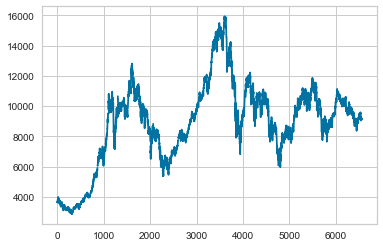

In [408]:
ibex_df.Close.plot()

IN the previous graph it can be seen cerain level, which IBex index has some difficulties to cross. They are supports and resistances. This levels are relevant and shoud be introduce somehow to the dataframe.

Text(0, 0.5, '# of instances')

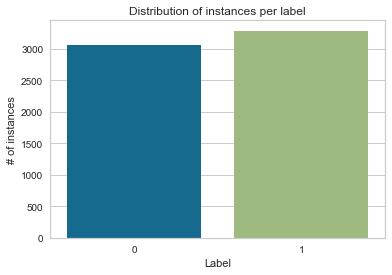

In [409]:
#Label distribution checking
counter = Counter(y)
dist_plot=sns.barplot(x=list(counter.keys()), y=list(counter.values()))
dist_plot.set_title('Distribution of instances per label')
dist_plot.set_xlabel('Label')
dist_plot.set_ylabel('# of instances')

In [410]:
ratio_labels= [x/len(y) for x in list(counter.values())]
ratio_labels

[0.4822974036191975, 0.5177025963808025]

There are slightly more 'green' (target =1) days than 'red' days (target = 0). Scorings =< 0,52 should considered no predictin at all.

### Cleaning the data set

There is several days with null values, let's consider them as days when market was closed and assign them values of the previous day when market was open with a volume of negotiation=0.

In [411]:
index_null=list(ibex_df[ibex_df['Low'].isnull()].index)#index of null raws 

In [412]:
#Change nan values for the value of previous day:
for i in index_null:
    for j in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        new_value = ibex_df.iloc[i-1][j]
        ibex_df.iloc[i, ibex_df.columns.get_loc(j)] = new_value
        
#Change nan values for volume to 0
ibex_df['Volume'].fillna(0,inplace=True)

In [413]:
ibex_df.isnull().sum() #null values:

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Target       0
dtype: int64

In [414]:
ibex_df.reset_index(inplace=True)

In [415]:
ibex_df. rename(columns = {'index':'day'}, inplace = True)

In [416]:
ibex_df.drop('Date', axis=1, inplace=True)
ibex_df0=ibex_df.copy()
ibex_df0

,day,Open,High,Low,Close,Adj Close,Volume,Target
0,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,3,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,0
4,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
...,...,...,...,...,...,...,...,...
6549,6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0
6550,6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0
6551,6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0
6552,6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0


### Engineering the data set

Variation of prices on the same day and the daily oscillation may be relevant, they will be included in the data frame:

In [417]:
ibex_df['Oscillation']   = ibex_df['High']- ibex_df['Low']
ibex_df['daily_variation']= ibex_df['Close']- ibex_df['Open']

In [418]:
ibex_df

,day,Open,High,Low,Close,Adj Close,Volume,Target,Oscillation,daily_variation
0,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,73.699951,39.300049
1,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,50.399902,-24.199951
2,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,41.800049,-4.000000
3,3,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,0,41.800049,-4.000000
4,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,45.699951,15.199951
...,...,...,...,...,...,...,...,...,...,...
6549,6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,69.699218,24.299804
6550,6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,89.899414,-9.500000
6551,6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,92.000000,-28.600586
6552,6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,81.600586,-32.700195


In [419]:
ibex_df2=ibex_df.copy()

ibex_df2['MA_200_dias'] = ibex_df2['Close'].rolling(200).mean()
ibex_df2['MA_20_dias'] = ibex_df2['Close'].rolling(20).mean()
ibex_df2['MA_5_dias'] = ibex_df2['Close'].rolling(5).mean()
ibex_df2['MA_3_dias'] = ibex_df2['Close'].rolling(3).mean()
ibex_df2

,day,Open,High,Low,Close,Adj Close,Volume,Target,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias
0,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,73.699951,39.300049,NaN,NaN,NaN,NaN
1,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,50.399902,-24.199951,NaN,NaN,NaN,NaN
2,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,41.800049,-4.000000,NaN,NaN,NaN,3635.333333
3,3,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,0,41.800049,-4.000000,NaN,NaN,NaN,3624.233317
4,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,45.699951,15.199951,NaN,NaN,3632.719971,3626.266601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,69.699218,24.299804,9157.978975,9266.144873,9191.919922,9173.599935
6550,6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,89.899414,-9.500000,9156.050478,9251.664892,9195.259961,9168.333333
6551,6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,92.000000,-28.600586,9154.357476,9235.394873,9185.800000,9194.266602
6552,6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,81.600586,-32.700195,9152.224976,9210.889892,9155.459961,9162.900065


As it is relevant the resistance and supports from a technical point of view, new columns are added. 
In ibex_df3 only distance to resistances are included:

In [420]:
ibex_df3=ibex_df2.copy()
ibex_df3['dist_Max_200_d'] = ibex_df3['Close']-ibex_df3['Close'].rolling(200).max()
ibex_df3['dist_Max_50_d'] = ibex_df3['Close']-ibex_df3['Close'].rolling(50).max()
ibex_df3['dist_Max_20_d'] = ibex_df3['Close']-ibex_df3['Close'].rolling(20).max()
ibex_df3

,day,Open,High,Low,Close,Adj Close,Volume,Target,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d
0,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,73.699951,39.300049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,50.399902,-24.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,41.800049,-4.000000,NaN,NaN,NaN,3635.333333,NaN,NaN,NaN
3,3,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,0,41.800049,-4.000000,NaN,NaN,NaN,3624.233317,NaN,NaN,NaN
4,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,45.699951,15.199951,NaN,NaN,3632.719971,3626.266601,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,69.699218,24.299804,9157.978975,9266.144873,9191.919922,9173.599935,-485.200196,-407.300782,-396.000000
6550,6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,89.899414,-9.500000,9156.050478,9251.664892,9195.259961,9168.333333,-443.399414,-365.500000,-354.199218
6551,6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,92.000000,-28.600586,9154.357476,9235.394873,9185.800000,9194.266602,-468.000000,-390.100586,-378.799804
6552,6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,81.600586,-32.700195,9152.224976,9210.889892,9155.459961,9162.900065,-579.299805,-501.400391,-337.700195


In ibex_df4, the supports also were added:

In [421]:
ibex_df4=ibex_df3.copy()

In [422]:
ibex_df4['dist_Min_200_d'] = ibex_df4['Close']-ibex_df4['Close'].rolling(200).min()
ibex_df4['dist_Min_50_d'] = ibex_df4['Close']-ibex_df4['Close'].rolling(50).min()
ibex_df4['dist_Min_20_d'] = ibex_df4['Close']-ibex_df4['Close'].rolling(20).min()
ibex_df4

,day,Open,High,Low,Close,Adj Close,Volume,Target,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d,dist_Min_200_d,dist_Min_50_d,dist_Min_20_d
0,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,73.699951,39.300049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,50.399902,-24.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,41.800049,-4.000000,NaN,NaN,NaN,3635.333333,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,0,41.800049,-4.000000,NaN,NaN,NaN,3624.233317,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,45.699951,15.199951,NaN,NaN,3632.719971,3626.266601,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,69.699218,24.299804,9157.978975,9266.144873,9191.919922,9173.599935,-485.200196,-407.300782,-396.000000,810.699218,127.799804,127.799804
6550,6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,89.899414,-9.500000,9156.050478,9251.664892,9195.259961,9168.333333,-443.399414,-365.500000,-354.199218,852.500000,169.600586,169.600586
6551,6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,92.000000,-28.600586,9154.357476,9235.394873,9185.800000,9194.266602,-468.000000,-390.100586,-378.799804,827.899414,145.000000,145.000000
6552,6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,81.600586,-32.700195,9152.224976,9210.889892,9155.459961,9162.900065,-579.299805,-501.400391,-337.700195,716.599609,33.700195,33.700195


In [423]:
ibex_df4.columns

Index(['day', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target',
       'Oscillation', 'daily_variation', 'MA_200_dias', 'MA_20_dias',
       'MA_5_dias', 'MA_3_dias', 'dist_Max_200_d', 'dist_Max_50_d',
       'dist_Max_20_d', 'dist_Min_200_d', 'dist_Min_50_d', 'dist_Min_20_d'],
      dtype='object')

## Model screening

With Pycaret we test all previous dataframes with a variety of classification models to check the metrics of the performance between models and also between dataframes:

In [233]:
setup(ibex_df0,
          target='Target'
    )
best_model_ibex_df0=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5424,0.5552,0.5848,0.5571,0.5703,0.0814,0.0817,0.0830
rf,Random Forest Classifier,0.5385,0.5489,0.5647,0.5557,0.5600,0.0748,0.0748,0.5550
dt,Decision Tree Classifier,0.5317,0.5310,0.5568,0.5500,0.5532,0.0613,0.0613,0.0240
et,Extra Trees Classifier,0.5274,0.5431,0.5559,0.5447,0.5502,0.0524,0.0524,0.5160
lr,Logistic Regression,0.5204,0.5045,1.0000,0.5204,0.6845,0.0000,0.0000,1.7040
nb,Naive Bayes,0.5204,0.4859,1.0000,0.5204,0.6845,0.0000,0.0000,0.0160
ridge,Ridge Classifier,0.5204,0.0000,1.0000,0.5204,0.6845,0.0000,0.0000,0.0330
lda,Linear Discriminant Analysis,0.5204,0.4702,1.0000,0.5204,0.6845,0.0000,0.0000,0.0170
dummy,Dummy Classifier,0.5204,0.5000,1.0000,0.5204,0.6845,0.0000,0.0000,0.0140
knn,K Neighbors Classifier,0.5180,0.5272,0.5597,0.5350,0.5468,0.0325,0.0326,0.0470


In [226]:
setup(ibex_df,
          target='Target'
    )
best_model_ibex_df=compare_models() 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5298,0.5276,0.6049,0.5370,0.5687,0.0556,0.0562,0.4020
et,Extra Trees Classifier,0.5287,0.5263,0.5514,0.5398,0.5453,0.0561,0.0562,0.4950
ada,Ada Boost Classifier,0.5245,0.5301,0.6296,0.5312,0.5750,0.0436,0.0446,0.1470
rf,Random Forest Classifier,0.5202,0.5309,0.5387,0.5321,0.5346,0.0393,0.0395,0.5180
knn,K Neighbors Classifier,0.5191,0.5187,0.5527,0.5298,0.5407,0.0364,0.0366,0.0600
lr,Logistic Regression,0.5132,0.5100,1.0000,0.5132,0.6783,0.0000,0.0000,0.0280
dummy,Dummy Classifier,0.5132,0.5000,1.0000,0.5132,0.6783,0.0000,0.0000,0.0110
ridge,Ridge Classifier,0.5117,0.0000,0.9669,0.5128,0.6699,-0.0014,0.0015,0.0140
lda,Linear Discriminant Analysis,0.5117,0.4810,0.9669,0.5128,0.6699,-0.0014,0.0015,0.0180
lightgbm,Light Gradient Boosting Machine,0.5104,0.5220,0.5471,0.5225,0.5342,0.0187,0.0187,0.0630


In [225]:
setup(ibex_df2,
          target='Target'
    )
best_model_ibex_df2=compare_models() 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5764,0.6040,0.5917,0.5913,0.5912,0.1516,0.1518,0.7500
rf,Random Forest Classifier,0.5718,0.5917,0.5959,0.5854,0.5902,0.1419,0.1422,0.7280
lightgbm,Light Gradient Boosting Machine,0.5701,0.5898,0.6014,0.5824,0.5914,0.1380,0.1383,0.0880
gbc,Gradient Boosting Classifier,0.5531,0.5772,0.6511,0.5588,0.6012,0.0995,0.1012,0.4940
dt,Decision Tree Classifier,0.5511,0.5508,0.5640,0.5669,0.5652,0.1013,0.1014,0.0490
ada,Ada Boost Classifier,0.5337,0.5360,0.6423,0.5417,0.5873,0.0598,0.0613,0.2800
knn,K Neighbors Classifier,0.5333,0.5444,0.5703,0.5476,0.5586,0.0638,0.0639,0.0400
ridge,Ridge Classifier,0.5182,0.0000,0.9058,0.5200,0.6604,0.0077,0.0159,0.0140
qda,Quadratic Discriminant Analysis,0.5182,0.5296,0.5602,0.5338,0.5451,0.0333,0.0336,0.0120
lda,Linear Discriminant Analysis,0.5182,0.5011,0.9058,0.5200,0.6604,0.0077,0.0159,0.0190


In [227]:
setup(ibex_df3,
          target='Target'
    )
best_model_ibex_df3=compare_models() 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6307,0.6722,0.6526,0.6412,0.6467,0.2599,0.2602,0.4030
rf,Random Forest Classifier,0.6154,0.6544,0.6434,0.6254,0.6339,0.2290,0.2294,0.7790
lightgbm,Light Gradient Boosting Machine,0.5921,0.6229,0.6312,0.6016,0.6159,0.1816,0.1819,0.0980
dt,Decision Tree Classifier,0.5875,0.5871,0.5980,0.6035,0.6005,0.1742,0.1743,0.0440
knn,K Neighbors Classifier,0.5487,0.5576,0.5904,0.5611,0.5752,0.0945,0.0948,0.0480
gbc,Gradient Boosting Classifier,0.5485,0.5756,0.6577,0.5543,0.6013,0.0893,0.0913,0.6870
ada,Ada Boost Classifier,0.5247,0.5354,0.6308,0.5351,0.5788,0.0417,0.0426,0.3540
qda,Quadratic Discriminant Analysis,0.5204,0.5202,0.7729,0.5256,0.6248,0.0218,0.0255,0.0120
lr,Logistic Regression,0.5184,0.5145,1.0000,0.5184,0.6828,0.0000,0.0000,0.0220
dummy,Dummy Classifier,0.5184,0.5000,1.0000,0.5184,0.6828,0.0000,0.0000,0.0150


In [228]:
setup(ibex_df4,
          target='Target'
    )
best_model_ibex_df4=compare_models() 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6374,0.6827,0.6650,0.6472,0.6558,0.2729,0.2733,0.5100
rf,Random Forest Classifier,0.6224,0.6627,0.6511,0.6330,0.6417,0.2427,0.2431,0.9260
lightgbm,Light Gradient Boosting Machine,0.5932,0.6235,0.6378,0.6027,0.6196,0.1832,0.1837,0.1310
dt,Decision Tree Classifier,0.5858,0.5855,0.5975,0.6034,0.6000,0.1705,0.1707,0.0570
gbc,Gradient Boosting Classifier,0.5576,0.5772,0.6457,0.5652,0.6026,0.1087,0.1101,0.8450
knn,K Neighbors Classifier,0.5511,0.5693,0.5912,0.5652,0.5775,0.0991,0.0994,0.0680
ada,Ada Boost Classifier,0.5284,0.5372,0.6101,0.5410,0.5734,0.0504,0.0510,0.2560
lr,Logistic Regression,0.5199,0.5124,1.0000,0.5199,0.6842,0.0000,0.0000,0.0250
dummy,Dummy Classifier,0.5199,0.5000,1.0000,0.5199,0.6842,0.0000,0.0000,0.0130
qda,Quadratic Discriminant Analysis,0.5186,0.5215,0.6742,0.5299,0.5922,0.0244,0.0252,0.0160


In [230]:
best_model_ibex_df.score

<bound method ClassifierMixin.score of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7463, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

To summarise:
    * Ibex_df0: data cleaned with no extra columns 
    * Ibex_df1: data cleaned adding 2 columns: daily oscillation and daily variation.
    * Ibex_df2: data frame Ibex_df1 adding columns for Moving averages of different lapses.
    * Ibex_df3: data frame Ibex_df2 adding columns for relevant resistance levels.
    * Ibex_df4: data frame Ibex_df3 adding columns for relevant supports levels.
        

## Model optimization

In [348]:
def scoring_f1(y_test,X_test,method): #generation of f1 macro
    f1score=f1_score(y_test,
                     method.predict(X_test),
                     average= 'macro'
)        
    return f1score  

In [341]:
X=ibex_df4.copy()
X.dropna(axis=0,inplace= True)
y=X.Target
X.reset_index(inplace=True)
X.drop('Target',axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=42
                                                    )

In [342]:
param_test1 = {'n_estimators':range(20,300,10)}
gsearch1 = GridSearchCV(estimator = ExtraTreesClassifier(),
                        param_grid = param_test1, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecate

In [343]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 240}, 0.689068136145903)

In [351]:
scoring_f1(y_test,X_test,gsearch1)

0.7137069661061817

In [345]:
param_test2 = {'n_estimators':[240], 'criterion': ['gini', 'entropy', 'log_loss']}
gsearch2 = GridSearchCV(estimator = ExtraTreesClassifier(),
                        param_grid = param_test2, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch2.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   16.7s remaining:    4.1s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   18.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecate

In [346]:
gsearch2.best_params_, gsearch2.best_score_

({'criterion': 'entropy', 'n_estimators': 240}, 0.6879447934176766)

In [350]:
scoring_f1(y_test,X_test,gsearch2)

0.7126813595129133

In [352]:
param_test3 = {'n_estimators':[240], 'criterion': ['entropy']}
gsearch3 = GridSearchCV(estimator = ExtraTreesClassifier(),
                        param_grid = param_test3, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch3.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   10.7s remaining:   16.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecate

## test_X prediction

To take advantage of all the dataset, the model with the best hyperparameters is fitted with the whole train data:

In [362]:
best_final_model = ExtraTreesClassifier(class_weight=None, 
                                  criterion='entropy',
                                max_depth=None, 
                                max_features='auto',
                                max_leaf_nodes=None,
                                max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0,
                                n_estimators=240, 
                                n_jobs=5,
                                random_state=None,
                                )

In [369]:
X.drop('index', axis=1,inplace=True)

In [370]:
best_final_model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=240, n_jobs=5,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

Charge test_X dataset to be predicted. First of all, additional columns have to be generated as the most useful dataframe (ibex_df4):

In [371]:
test_x=pd.read_csv('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/test_x.csv',index_col=None)

test_x.isnull().sum()

test_index    0
Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
dtype: int64

In [372]:
test_x.shape

(726, 8)

In [373]:

test_x

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [374]:
test_x. rename(columns = {'test_index':'day'}, inplace = True)
test_x.drop('Date',axis=1,inplace=True)

test_x

,day,Open,High,Low,Close,Adj Close,Volume
0,6557,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...
721,7278,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [375]:
test_x['Oscillation']   = test_x['High']- test_x['Low']
test_x['daily_variation']= test_x['Close']- test_x['Open']

test_x['MA_200_dias'] = test_x['Close'].rolling(200).mean()
test_x['MA_20_dias'] = test_x['Close'].rolling(20).mean()
test_x['MA_5_dias'] = test_x['Close'].rolling(5).mean()
test_x['MA_3_dias'] = test_x['Close'].rolling(3).mean()

test_x['dist_Max_200_d'] = test_x['Close']-test_x['Close'].rolling(200).max()
test_x['dist_Max_50_d'] = test_x['Close']-test_x['Close'].rolling(50).max()
test_x['dist_Max_20_d'] = test_x['Close']-test_x['Close'].rolling(20).max()

test_x['dist_Min_200_d'] = test_x['Close']-test_x['Close'].rolling(200).min()
test_x['dist_Min_50_d'] = test_x['Close']-test_x['Close'].rolling(50).min()
test_x['dist_Min_20_d'] = test_x['Close']-test_x['Close'].rolling(20).min()


In [376]:
index_new=list(test_x.day)

In [377]:
test_x.index=index_new
test_x

,day,Open,High,Low,Close,Adj Close,Volume,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d,dist_Min_200_d,dist_Min_50_d,dist_Min_20_d
6557,6557,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,78.400391,13.700195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6558,6558,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,109.500000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6559,6559,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,75.700196,49.399414,NaN,NaN,NaN,9185.266601,NaN,NaN,NaN,NaN,NaN,NaN
6560,6560,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,54.100586,9.899414,NaN,NaN,NaN,9233.133138,NaN,NaN,NaN,NaN,NaN,NaN
6561,6561,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,59.099609,-6.500000,NaN,NaN,9226.399804,9270.766276,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278,7278,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0,76.700195,16.500000,8716.979521,8202.210010,8368.100000,8321.366536,-865.300782,-555.600586,-156.600586,685.999511,685.999511,685.999511
7279,7279,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0,131.299804,11.199218,8712.828018,8196.529980,8363.379883,8333.766276,-817.000000,-520.600586,-121.600586,720.999511,720.999511,720.999511
7280,7280,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0,201.299805,163.599609,8710.748018,8217.849951,8388.859765,8436.932942,-568.000000,-271.600586,0.000000,969.999511,969.999511,969.999511
7281,7281,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0,88.500000,-32.700196,8708.242515,8229.329932,8433.299609,8510.266276,-632.000000,-335.600586,-64.000000,905.999511,905.999511,905.999511


To fill the nan values in the test_x, it can be concatenated to initial dataframe to calculate moving averages, distances to maximums an minimums:

In [378]:
ibex_df4_NoTarget=ibex_df4.copy()
ibex_df4_NoTarget.drop('Target', axis=1,inplace=True)
ibex_df4_NoTarget

,day,Open,High,Low,Close,Adj Close,Volume,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d,dist_Min_200_d,dist_Min_50_d,dist_Min_20_d
0,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,73.699951,39.300049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,50.399902,-24.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,41.800049,-4.000000,NaN,NaN,NaN,3635.333333,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,41.800049,-4.000000,NaN,NaN,NaN,3624.233317,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,45.699951,15.199951,NaN,NaN,3632.719971,3626.266601,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,69.699218,24.299804,9157.978975,9266.144873,9191.919922,9173.599935,-485.200196,-407.300782,-396.000000,810.699218,127.799804,127.799804
6550,6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,89.899414,-9.500000,9156.050478,9251.664892,9195.259961,9168.333333,-443.399414,-365.500000,-354.199218,852.500000,169.600586,169.600586
6551,6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,92.000000,-28.600586,9154.357476,9235.394873,9185.800000,9194.266602,-468.000000,-390.100586,-378.799804,827.899414,145.000000,145.000000
6552,6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,81.600586,-32.700195,9152.224976,9210.889892,9155.459961,9162.900065,-579.299805,-501.400391,-337.700195,716.599609,33.700195,33.700195


In [379]:
total_ibex_df.iloc[6554:6753] #raws of the test_x with nan:

,day,Open,High,Low,Close,Adj Close,Volume,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d,dist_Min_200_d,dist_Min_50_d,dist_Min_20_d
6557,6557,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,78.400391,13.700195,9149.695474,9184.914893,9159.400000,9129.599935,-509.299805,-431.400391,-180.500000,786.599609,103.700195,103.700195
6558,6558,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,109.500000,0.000000,9148.454976,9176.824902,9149.959961,9159.166667,-490.599610,-412.700196,-135.099610,805.299804,122.400390,122.400390
6559,6559,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,75.700196,49.399414,9147.292476,9176.874902,9158.819922,9185.266601,-423.700196,-345.800782,-68.200196,872.199218,189.299804,189.299804
6560,6560,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,54.100586,9.899414,9146.017974,9180.229883,9201.539844,9233.133138,-365.700196,-287.800782,-10.200196,930.199218,247.299804,247.299804
6561,6561,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,59.099609,-6.500000,9144.527471,9189.574853,9226.399804,9270.766276,-377.700196,-299.800782,-22.200196,918.199218,235.299804,235.299804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6751,6751,8960.799805,8962.500000,8639.900391,8683.000000,8683.000000,342803500.0,322.599609,-277.799805,9264.126755,9507.584961,8773.859961,8801.533203,-1400.599609,-1400.599609,-1400.599609,164.000000,0.000000,0.000000
6752,6752,8532.599609,8542.000000,8310.400391,8375.599609,8375.599609,345901100.0,231.599609,-157.000000,9260.131755,9435.814941,8704.339844,8656.199870,-1708.000000,-1708.000000,-1708.000000,0.000000,0.000000,0.000000
6753,6753,7884.000000,8022.899902,7621.399902,7708.700195,7708.700195,598769200.0,401.500000,-175.299805,9252.593254,9330.449951,8497.779883,8255.766601,-2374.899414,-2374.899414,-2374.899414,0.000000,0.000000,0.000000
6754,6754,7815.600098,8007.700195,7440.600098,7461.500000,7461.500000,506034000.0,567.100097,-354.100098,9243.941755,9209.394971,8227.759961,7848.599935,-2622.099609,-2622.099609,-2622.099609,0.000000,0.000000,0.000000


In [380]:
total_ibex_df  = pd.concat([ibex_df4_NoTarget,test_x])
total_ibex_df.shape

(7280, 19)

In [381]:
total_ibex_df['Oscillation']   = total_ibex_df['High']- total_ibex_df['Low']
total_ibex_df['daily_variation']= total_ibex_df['Close']- total_ibex_df['Open']

total_ibex_df['MA_200_dias'] = total_ibex_df['Close'].rolling(200).mean()
total_ibex_df['MA_20_dias'] = total_ibex_df['Close'].rolling(20).mean()
total_ibex_df['MA_5_dias'] = total_ibex_df['Close'].rolling(5).mean()
total_ibex_df['MA_3_dias'] = total_ibex_df['Close'].rolling(3).mean()

total_ibex_df['dist_Max_200_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(200).max()
total_ibex_df['dist_Max_50_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(50).max()
total_ibex_df['dist_Max_20_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(20).max()

total_ibex_df['dist_Min_200_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(200).min()
total_ibex_df['dist_Min_50_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(50).min()
total_ibex_df['dist_Min_20_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(20).min()


In [382]:
test_x_modified= total_ibex_df.iloc[6554:].copy()
test_x_modified.shape

(726, 19)

In [385]:
x_test_pred=best_final_model.predict(test_x_modified)
x_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [397]:
predictions_df=pd.DataFrame({'Predictions': list(x_test_pred)} )

In [401]:
predictions_df['test_index']=index_new
predictions_df.index= predictions_df['test_index']
predictions_df.drop('test_index',axis=1,inplace=True)
predictions_df

,Predictions
test_index,
6557,0
6558,0
6559,0
6560,0
6561,0
...,...
7278,1
7279,1
7280,1


In [402]:
predictions_df.to_csv('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/predictions.csv')

In [403]:
predictions_df.to_json('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/predictions.json')

# Data Sentiment Study

In [438]:
import pysentimiento

In [425]:
tweet_df=pd.read_csv('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/tweets_from2015_#Ibex35.csv')

In [431]:
tweet_df

,tweetDate,handle,text,año
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,He hecho el repaso de todos los componentes de...,object
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,Els projectes que han presentat les empreses d...,object
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ...",object
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...,object
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0...",object
...,...,...,...,...
9796,Thu Jan 08 16:41:36 +0000 2015,elEconomistaes,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1...",object
9797,Sat Jan 03 17:20:30 +0000 2015,Roger_bolsa,Un vistazo a los #Bluechips del #Ibex #Ibex35....,object
9798,Sat Jan 10 19:42:45 +0000 2015,Secretosdebolsa,Así comienza la #Bolsa en #2015 Ojo a los sopo...,object
9799,Sat Jan 10 21:47:17 +0000 2015,Roger_bolsa,Análisis del #BancoSantander #Santander #SAN t...,object
